In [1]:
import yfinance as yahooFinance
import numpy as np
import seaborn as sns
from ncps import wirings
from ncps.tf import LTC
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch.nn as nn
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as torchdata

2024-01-10 22:51:46.496646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-10 22:51:46.496692: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-10 22:51:46.497337: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-10 22:51:46.501330: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-10 22:51:47.119692: W tensorflow/compiler/tf2

In [2]:
def get_data(ticker, period="max"):
    info = yahooFinance.Ticker(ticker)

    # Valid periods are 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, and max.
    return info.history(period=period)

data = get_data("META", period="1y")
data =  data["Close"]
data = data.to_numpy()

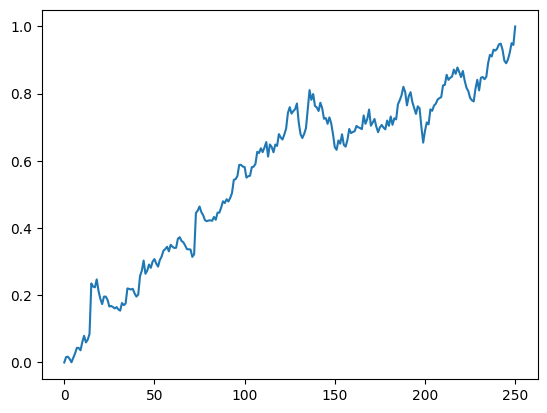

In [3]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data = scaler.fit_transform(data.reshape(-1, 1))

plt.plot(scaled_data)
plt.show()

In [4]:
train_days = 30

x_train = []
y_train = []

for x in range(train_days, len(scaled_data)):
  x_train.append(scaled_data[x - train_days:x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train.shape)

(221, 30)


In [5]:
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [6]:
wiring = wirings.AutoNCP(16, 1) # 24 neurons, 1 outputs

rnn = LTC(30, wiring, batch_first=True)
learn = SequenceLearner(rnn, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=100,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


alloc!


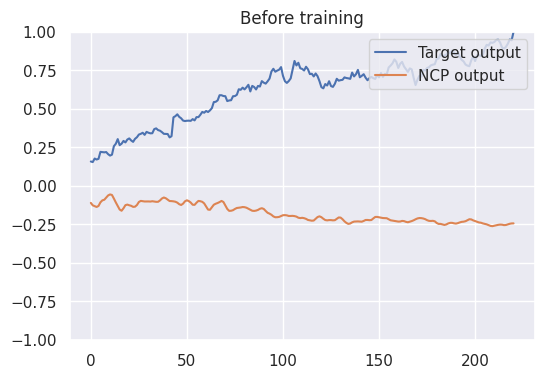

In [7]:
x_tensor = torch.from_numpy(x_train)
y_tensor = torch.from_numpy(y_train)

with torch.no_grad():
    prediction = rnn(x_tensor)
    
plt.figure(figsize=(6, 4))
plt.plot(y_tensor, label="Target output")
plt.plot(prediction[0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [8]:
torch.set_float32_matmul_precision('medium')
                                   
dataloader = torchdata.DataLoader(
    torchdata.TensorDataset(x_tensor, y_tensor), batch_size=11, shuffle=True, num_workers=4
)

trainer.fit(learn, dataloader)

/home/alex/Y4/FYP/env/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 3.8 K 
-------------------------------
3.1 K     Trainable params
736       Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)
/home/alex/Y4/FYP/env/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:293: The number of training batches (21) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 21/21 [00:01<00:00, 12.56it/s, v_num=6, train_loss=1.57e-6] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 21/21 [00:01<00:00, 12.50it/s, v_num=6, train_loss=1.57e-6]


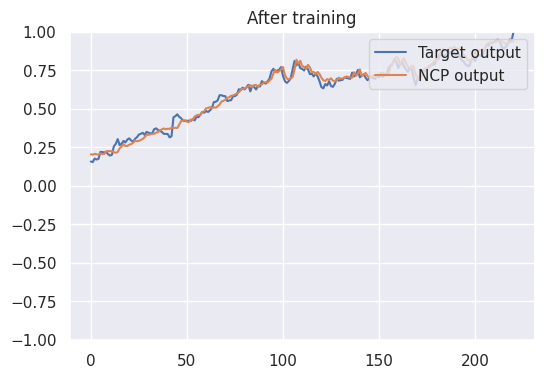

In [10]:
with torch.no_grad():
    prediction = rnn(x_tensor)
    
plt.figure(figsize=(6, 4))
plt.plot(y_tensor, label="Target output")
plt.plot(torch.rot90(prediction[0])[0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()